In [48]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torchvision import datasets,transforms
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F
%matplotlib inline

# transforms.ToTensor:
    1.将我们读取的图片或是其他类型的数据转换为tensor
    2.将数据归一化，转换到0~1之间
    3.会将channel这个维度放到第一维度

In [2]:
transformation=transforms.Compose([
    transforms.ToTensor()
])

In [3]:
train_ds=datasets.MNIST(
    'data/',
    train=True,
    transform=transformation,
    download=True
)

In [4]:
text_ds=datasets.MNIST(
    'data/',
    train=False,
    transform=transformation,
    download=True
)

In [5]:
train_dl=DataLoader(train_ds,batch_size=64,shuffle=True)
text_dl=DataLoader(text_ds,batch_size=256) #验证数据集可以切片切的大一点，因为不用反向传播所以占用资源少

In [6]:
img,label=next(iter(train_dl))  #取出一个批次的图片和标签

In [8]:
img.shape   #看一下这个批次的图片，因为批次是64，所以有64个
            #这四个参数分别是:batch_size,channel,high,width

torch.Size([64, 1, 28, 28])

# 在pytorch里图片的表示形式就是这样的[batch_size,channel,high,width]
 ToTensor会将channel这个维度放到第一维度，这是和其他方法最大的不同，如果是电脑中的普通图片则是长宽，channel（rgb通道）

In [9]:
image=img[0]  #取出一张图片

In [10]:
image.shape

torch.Size([1, 28, 28])

In [11]:
image=image.numpy() #想要绘图就得用ndarray

In [12]:
image=np.squeeze(image) #第一个维度channel没有用，去掉

In [13]:
image.shape

(28, 28)

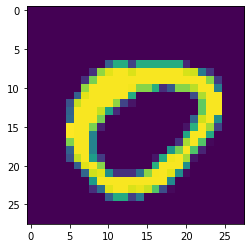

In [14]:
plt.imshow(image)

In [15]:
label[0]  #这张图片就是1

tensor(0)

In [16]:
def imshow(img):
    npimg=img.numpy()      #转化为numpy
    npimg=np.squeeze(npimg)#去除第一维度
    plt.imshow(npimg)      #显示图片

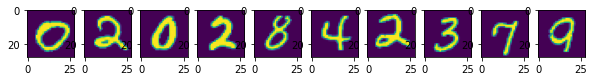

In [17]:
plt.figure(figsize=(10,1))             #创建画布
for i,img in enumerate(img[:10]):     #enumerate相当于是每次返回img[i]
    plt.subplot(1,10,i+1)             #创建10张子图  三个参数分别是一行十列绘制img的第几个（img[i]）
    imshow(img)

In [18]:
label[:10]

tensor([0, 2, 0, 2, 8, 4, 2, 3, 7, 9])

# 将数据展平，创建全连接模型

In [33]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()             #继承之前的初始化
        self.linear_1=nn.Linear(28*28,120)  #因为要展平，所以输入是28*28，输出也可以多一点
        self.linear_2=nn.Linear(120,84)  #中间层是超参数，取多少应该根据实验得出，看取多少效果好
        self.linear_3=nn.Linear(84,10)  #是个十分类问题，从数字0到9
    def forward(self,input):
        x=input.view(-1,28*28) #将输入展平
        x=F.relu(self.linear_1(x))
        x=F.relu(self.linear_2(x))
        x=self.linear_3(x) #因为是多分类，用的损失函数CrossEntropyLoss
                          #的输入是未激活的输出
        return x

In [34]:
model=Model()

In [35]:
model

Model(
  (linear_1): Linear(in_features=784, out_features=120, bias=True)
  (linear_2): Linear(in_features=120, out_features=84, bias=True)
  (linear_3): Linear(in_features=84, out_features=10, bias=True)
)

In [46]:
loss_fn=nn.CrossEntropyLoss()
opt=torch.optim.Adam(model.parameters(),lr=0.01)

In [41]:
def fit(epoch,model,trainloader,textloader):   #因为这个函数没有输入train_x和train_y所以直接用train_dl和text_dl来算正确率
    correct=0                            #通过记录预测正确的个数和样本总数之间的比值来看正确率
    total=0                              #总样本的个数
    running_loss=0
    for x,y in trainloader:    
        y_pred=model(x)
        loss=loss_fn(y_pred,y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        with torch.no_grad():                  #每一个y值进行一次计算，这是对训练数据
            y_pred=torch.argmax(y_pred,dim=1)
            correct+=(y_pred==y).sum().item()  #每一次正确的个数加到correct里
            total+=y.size(0)                   #每一批样本的个数
            running_loss+=loss.item()          #每一批样本的loss
        
        epoch_acc=correct/total                #正确率为正确个数除以样本个数
        epoch_loss=running_loss/len(trainloader.dataset)  #平均loss为一个批次的总loss除以训练的长度
        
        
        text_correct=0                          #这是对测试数据 ,对于测试数据不用反向传播不用优化
        text_total=0                              
        text_running_loss=0
        with torch.no_grad():                  
             for x,y in textloader:    
                y_pred=model(x)
                loss=loss_fn(y_pred,y)
                y_pred=torch.argmax(y_pred,dim=1)
                text_correct+=(y_pred==y).sum().item() 
                text_total+=y.size(0)                   
                text_running_loss+=loss.item()
        
        epoch_text_acc=text_correct/text_total                
        epoch_text_loss=running_loss/len(textloader.dataset)  
        
        print('epoch: ',epoch,'loss: ',round(epoch_loss,3),
                              'accuracy: ',round(epoch_acc,3),
                              'text_loss: ',round(epoch_text_loss,3),
                              'text_accuracy: ',round(epoch_text_acc,3))
        return epoch_loss,epoch_acc,epoch_text_loss,epoch_text_acc  
                                                    #这样就会将每个epoch上的这些平均正确率和平均损失返回

In [42]:
epochs=20

In [43]:
train_loss=[] #如果想把值保存下来就创建这四个列表
train_acc=[]
text_loss=[]
text_acc=[]

In [47]:
for epoch in range(epochs):
    epoch_loss,epoch_acc,epoch_text_loss,epoch_text_acc =fit(epoch,model,train_dl,text_dl)
    
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    text_loss.append(epoch_text_loss)
    text_acc.append(epoch_text_acc)

epoch:  0 loss:  0.0 accuracy:  0.828 text_loss:  0.0 text_accuracy:  0.362
epoch:  1 loss:  0.0 accuracy:  0.297 text_loss:  0.0 text_accuracy:  0.507
epoch:  2 loss:  0.0 accuracy:  0.438 text_loss:  0.0 text_accuracy:  0.604
epoch:  3 loss:  0.0 accuracy:  0.703 text_loss:  0.0 text_accuracy:  0.477
epoch:  4 loss:  0.0 accuracy:  0.5 text_loss:  0.0 text_accuracy:  0.484
epoch:  5 loss:  0.0 accuracy:  0.453 text_loss:  0.0 text_accuracy:  0.538
epoch:  6 loss:  0.0 accuracy:  0.562 text_loss:  0.0 text_accuracy:  0.58
epoch:  7 loss:  0.0 accuracy:  0.578 text_loss:  0.0 text_accuracy:  0.638
epoch:  8 loss:  0.0 accuracy:  0.641 text_loss:  0.0 text_accuracy:  0.662
epoch:  9 loss:  0.0 accuracy:  0.547 text_loss:  0.0 text_accuracy:  0.693
epoch:  10 loss:  0.0 accuracy:  0.672 text_loss:  0.0 text_accuracy:  0.755
epoch:  11 loss:  0.0 accuracy:  0.797 text_loss:  0.0 text_accuracy:  0.814
epoch:  12 loss:  0.0 accuracy:  0.844 text_loss:  0.0 text_accuracy:  0.823
epoch:  13 l